1. Проведите эксперимент с разными размерами изображений (например, 64x64, 128x128, 224x224, 512x512).
2. Для каждого размера измерьте время загрузки и применения аугментаций к 100 изображениям, а также потребление памяти.
3. Постройте графики зависимости времени и памяти от размера.

Размер изображения: (64, 64)
  Время обработки: 0.82 сек
  Использовано памяти: 40.11 МБ
Размер изображения: (128, 128)
  Время обработки: 0.75 сек
  Использовано памяти: 2.39 МБ
Размер изображения: (224, 224)
  Время обработки: 0.89 сек
  Использовано памяти: 4.12 МБ
Размер изображения: (512, 512)
  Время обработки: 1.76 сек
  Использовано памяти: 16.47 МБ


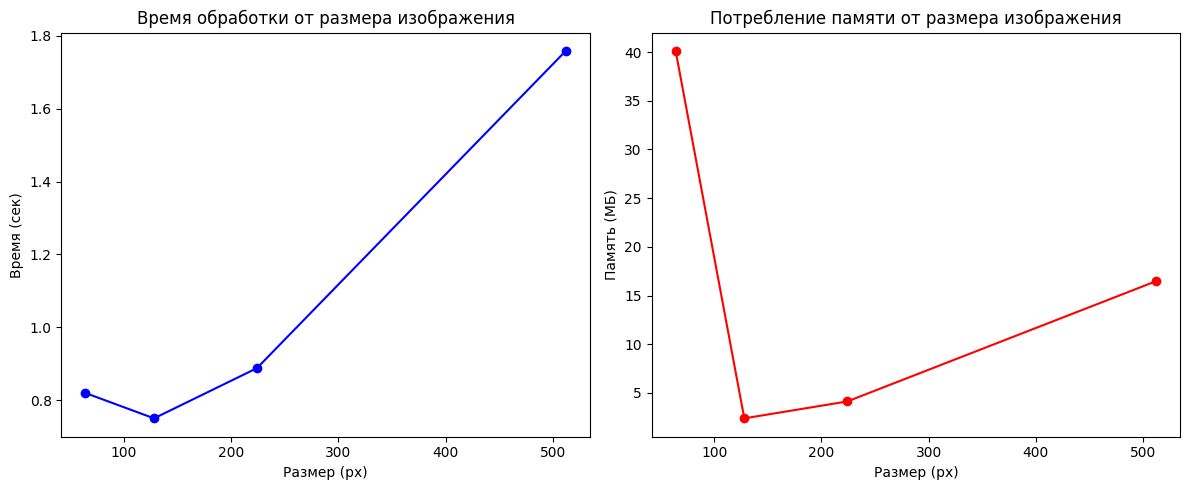

In [2]:
import time
import psutil
import torch
import matplotlib.pyplot as plt
from torchvision import transforms
from datasets import CustomImageDataset

device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
process = psutil.Process()

# Размеры изображений для эксперимента
sizes = [(64, 64), (128, 128), (224, 224), (512, 512)]
results = []

# Генерация аугментаций под каждый размер
def build_augmentation(size):
    crop_size = min(size) - 16 if min(size) > 32 else min(size)
    return transforms.Compose([
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomCrop(crop_size, padding=8),
        transforms.ColorJitter(0.3, 0.3, 0.3, 0.1),
        transforms.ToTensor()
    ])

# Основной цикл по размерам
for size in sizes:
    print(f"Размер изображения: {size}")

    augmentation = build_augmentation(size)
    dataset = CustomImageDataset('data/train', transform=augmentation, target_size=size)
    
    # Очистка памяти перед замером
    if device.type == 'mps':
        torch.mps.empty_cache()

    start_time = time.perf_counter()
    mem_before = process.memory_info().rss / (1024 ** 2)

    for i in range(100):
        img, label = dataset[i]
        _ = img.to(device)

    end_time = time.perf_counter()
    mem_after = process.memory_info().rss / (1024 ** 2)

    duration = end_time - start_time
    mem_used = mem_after - mem_before

    print(f"  Время обработки: {duration:.2f} сек")
    print(f"  Использовано памяти: {mem_used:.2f} МБ")

    results.append((size[0], duration, mem_used))

# Построение графиков
sizes_px = [r[0] for r in results]
times = [r[1] for r in results]
memories = [r[2] for r in results]

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(sizes_px, times, marker='o', color='blue')
plt.title("Время обработки от размера изображения")
plt.xlabel("Размер (px)")
plt.ylabel("Время (сек)")

plt.subplot(1, 2, 2)
plt.plot(sizes_px, memories, marker='o', color='red')
plt.title("Потребление памяти от размера изображения")
plt.xlabel("Размер (px)")
plt.ylabel("Память (МБ)")

plt.tight_layout()
plt.show()